In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.io as pio
import mne
import json
import glob
import os
from tqdm import tqdm
import time
from datetime import timedelta
from braindecode.datasets import BaseConcatDataset
from mne_features.feature_extraction import FeatureExtractor
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
from pyriemann.utils.distance import distance_riemann, distance_euclid, distance_logeuclid
from pyriemann.utils.mean import mean_riemann, mean_euclid, mean_logeuclid
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment, self_subject_label_alignment, relabel_dataset
from collections import defaultdict
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore') 

In [2]:
%%time
# fmt: off
subjects = [
    'K001', 'K002', 'K003', 'K004', 'K005', 
    'K006', 'K007', 'K008', 'K009', 'K010', 
    'K011', 'K012', 'K013', 'K015', 'K016', 
    'K017', 'K018', 'K021', 'K022', 'K023', 
    'K024', 'K025', 'K026', 'K027', 'K028', 
    'K300', 'K301', 'K302', 'K303', 'K304', 
    'K305', 'K306', 'K307', 'K308', 'K309', 
    'K310', 'K311', 'K312', 'K313', 'K314', 
    'K315', 'K316', 'K319', 'K320', 'K321', 
    'K322', 'K323', 'K324', 'K325', 'K326', 
    'K327', 'K328', 'K329', 'K330', 'K331', 
    'K332', 'K333', 'K334', 'K335', 'K336', 
    'K337', 'K338', 'K339', 'K342', 'K343', 
    'K344', 'K350', 'K351', 'K352', 'K353', 
    'K354', 'K355', 'K357', 'K358', 'K359', 
    'K360', 'K361', 'K362', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    # "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    # "PO9", "O1", "Oz", "O2", "PO10",
    "O1", "Oz", "O2",
]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    # "nâng chân trái_Thinking": "nâng chân trái",
    # "nâng chân phải_Thinking": "nâng chân phải",
    "nâng chân trái_Thinking": "nâng chân",
    "nâng chân phải_Thinking": "nâng chân",
    # "gật đầu_Thinking": "gật đầu",
    # "lắc đầu_Thinking": "lắc đầu",
    "gật đầu_Thinking": "gật/lắc đầu",
    "lắc đầu_Thinking": "gật/lắc đầu",
    "há miệng_Thinking": "há miệng",
    # "nâng tay trái_Thinking and Acting": "nâng tay trái",
    # "nâng tay phải_Thinking and Acting": "nâng tay phải",
    # "nâng chân trái_Thinking and Acting": "nâng chân trái",
    # "nâng chân phải_Thinking and Acting": "nâng chân phải",
    # "gật đầu_Thinking and Acting": "gật đầu",
    # "lắc đầu_Thinking and Acting": "lắc đầu",
    # "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

max_duration = {  # seconds
    # "nâng tay trái": 10,
    # "nâng tay phải": 10,
    # "nâng chân trái": 10,
    # "nâng chân phải": 10,
    # "gật đầu": 10,
    # "lắc đầu": 10,
    "rest": 20,
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

moving_standardize = False  # @param {"type": "boolean"}

ds = load_data(
    "../data/DataVIN/Official",  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    max_duration=max_duration,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=moving_standardize,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

als_subjects = [
    *(f"ALS01_t{i}" for i in range(1, 11)),
    *(f"ALS02_t{i}" for i in range(1, 11)),
    *(f"ALS03_t{i}" for i in range(1, 10)),
    *(f"ALS04_t{i}" for i in range(1, 9)),
    *(f"ALS05_t{i}" for i in range(1, 7)),
    *(f"ALS06_t{i}" for i in range(1, 4)),
]

als_ds = load_data(
    "../data/DataVIN/ALS/als-patients",  
    subjects=als_subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    max_duration=max_duration,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=moving_standardize,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# ds = als_ds
# subjects = als_subjects

ds = BaseConcatDataset([ds, als_ds])
subjects.extend(als_subjects)

# fmt: on

ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 28 channels


trial: 100%|████████████████████████████████████████████████████| 1041/1041 [00:02<00:00, 368.56it/s]


loaded 136 subjects - 37236 epochs
CPU times: user 59.5 s, sys: 3.22 s, total: 1min 2s
Wall time: 1min 3s


,subject,scenario,event,onset,label,label_idx,trial,split,epochs
0,K001,nâng tay trái,Thinking,6.7125,nâng tay trái,3,0,train,9
1,K001,nâng tay trái,Resting,13.1479,rest,0,0,train,10
2,K001,nâng tay trái,Resting,32.7215,rest,0,1,train,5
3,K001,nâng tay trái,Thinking,37.0182,nâng tay trái,3,1,train,10
4,K001,nâng tay trái,Thinking,62.7771,nâng tay trái,3,2,train,10
...,...,...,...,...,...,...,...,...,...
3316,ALS06_t3,nâng chân phải,Resting,19.3768,rest,0,0,train,11
3317,ALS06_t3,nâng chân phải,Thinking,26.8445,nâng chân,1,1,train,20
3318,ALS06_t3,nâng chân phải,Resting,38.4215,rest,0,1,train,11
3319,ALS06_t3,nâng chân phải,Thinking,45.6556,nâng chân,1,2,train,20


In [3]:
ch_idx = {ch: i for i, ch in enumerate(channels)}

In [4]:
euclidean_alignment(ds, target_subject=None)

subject: 100%|█████████████████████████████████████████████████████| 136/136 [00:03<00:00, 42.45it/s]


In [81]:
normal_subject = "K315"
als_subject = "ALS01_t9"

normal_subject_ds = BaseConcatDataset([ds.datasets[i] for i in ds_info[(ds_info["subject"] == normal_subject)].index])
als_subject_ds = BaseConcatDataset([ds.datasets[i] for i in ds_info[(ds_info["subject"] == als_subject)].index])

In [82]:
label = "rest"
# label = "nâng chân"
# label = "nâng tay phải"
# label = "nâng tay trái"

normal_epochs = mne.concatenate_epochs([_ds.windows for _ds in normal_subject_ds.datasets if _ds.description["label"] == label])
als_epochs = mne.concatenate_epochs([_ds.windows for _ds in als_subject_ds.datasets if _ds.description["label"] == label])

In [83]:
freqs, normal_psd = signal.welch(normal_epochs.get_data(), fs=128.0, nperseg=128, noverlap=64)
_, als_psd = signal.welch(als_epochs.get_data(), fs=128.0, nperseg=128, noverlap=64)

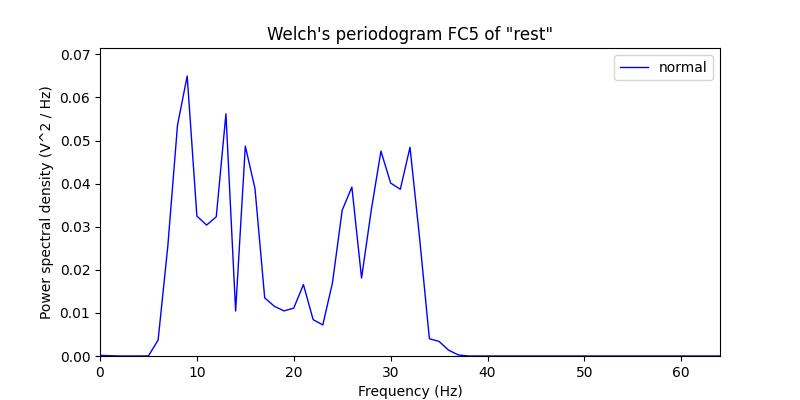

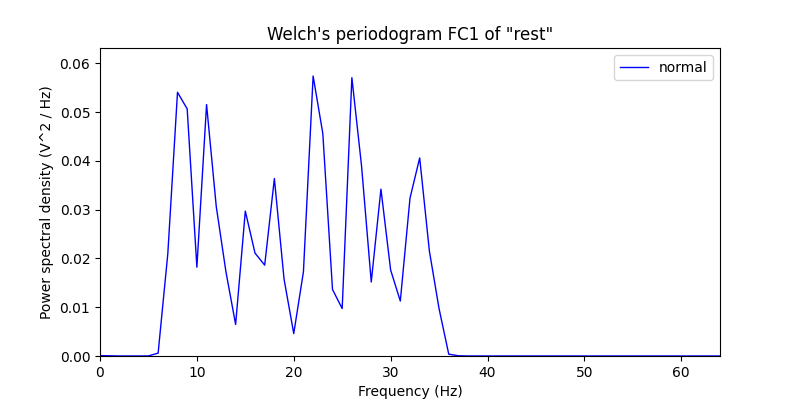

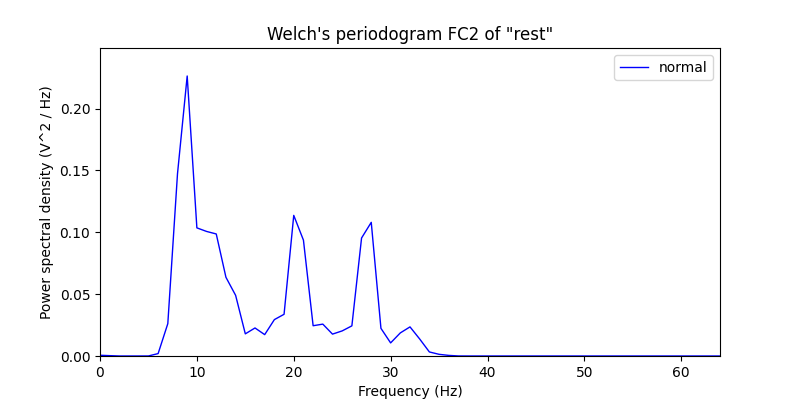

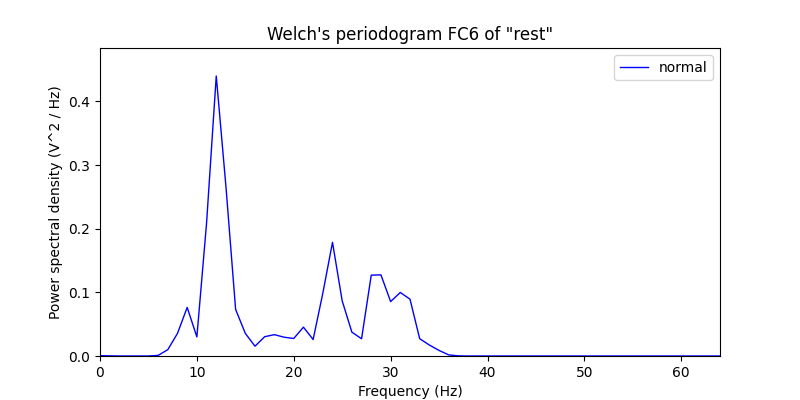

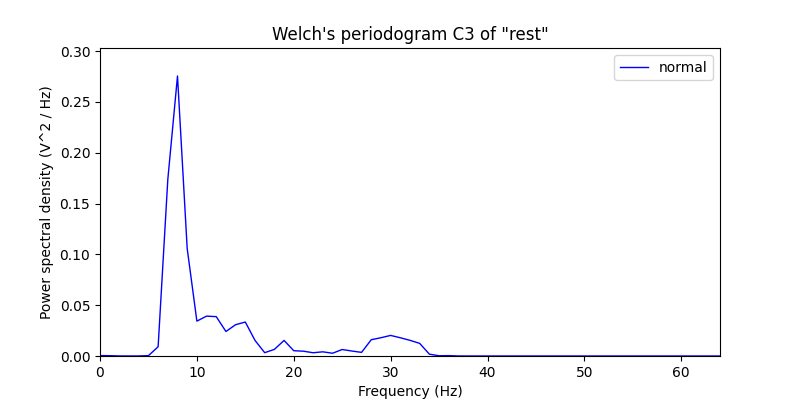

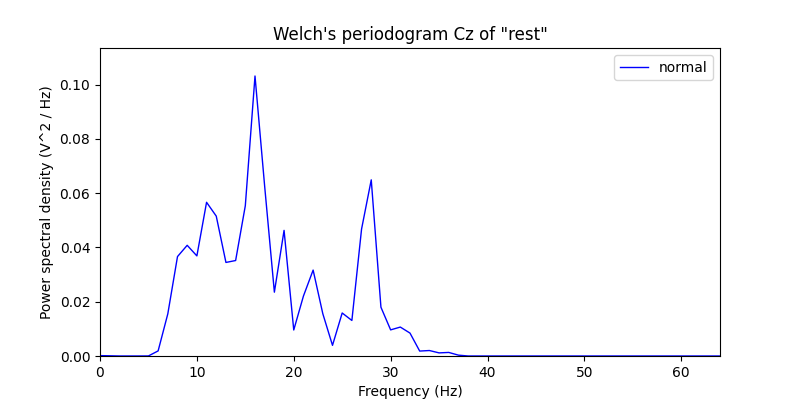

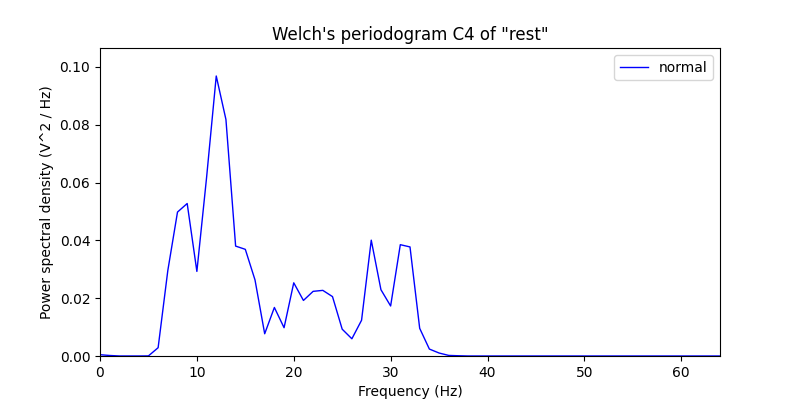

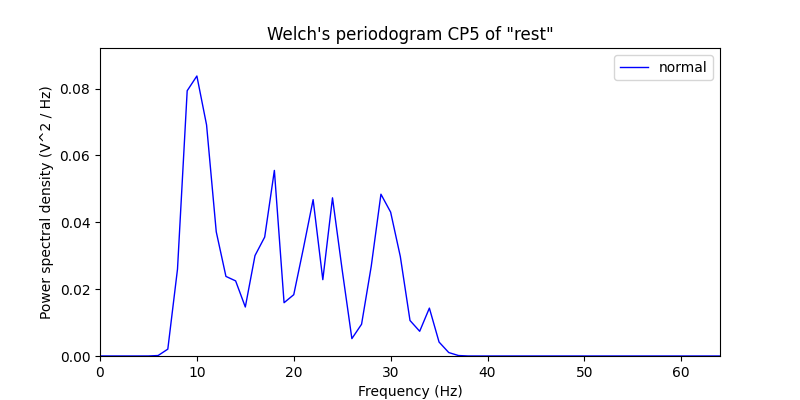

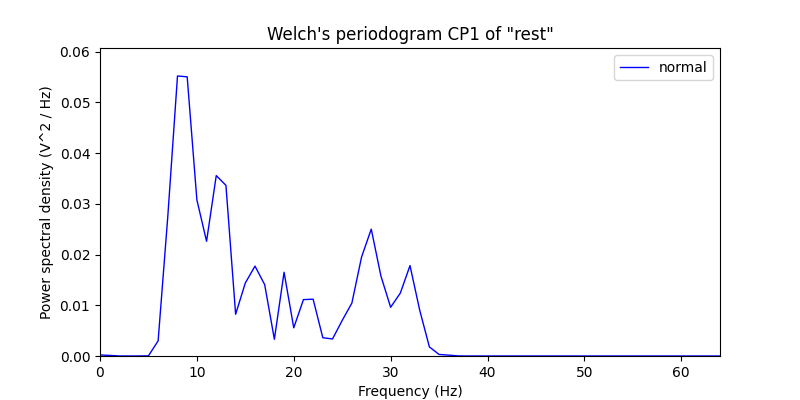

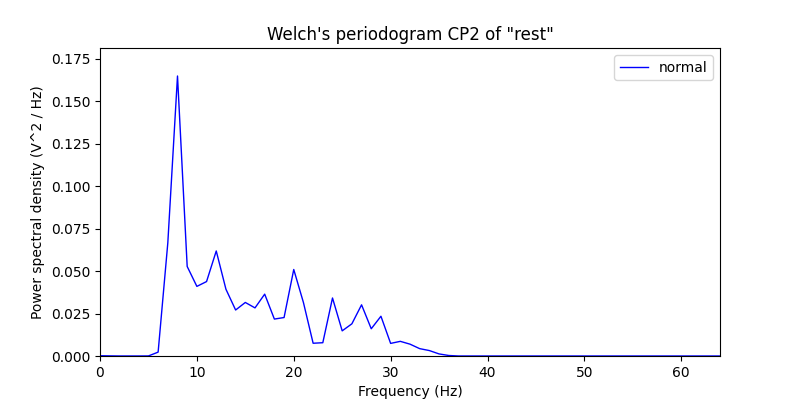

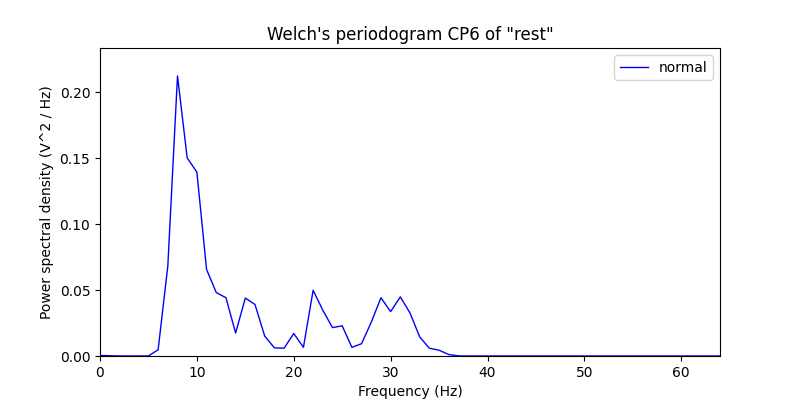

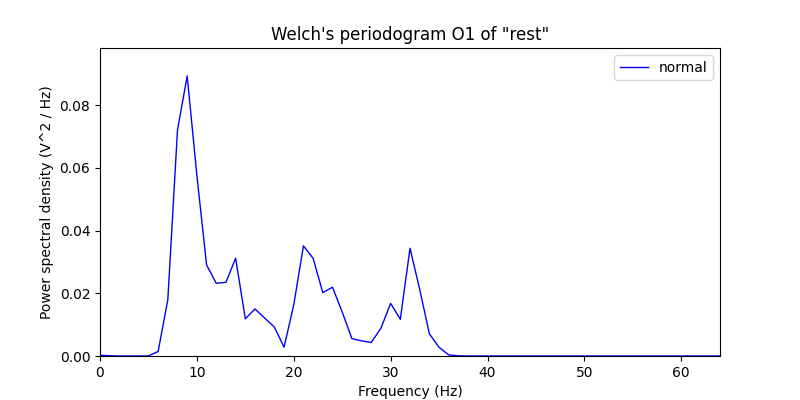

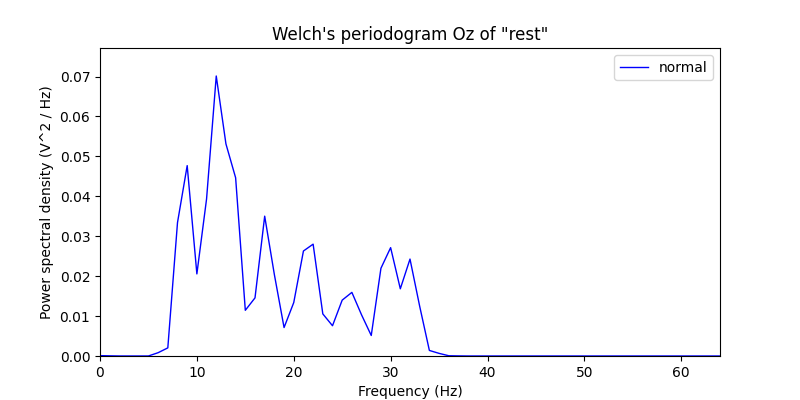

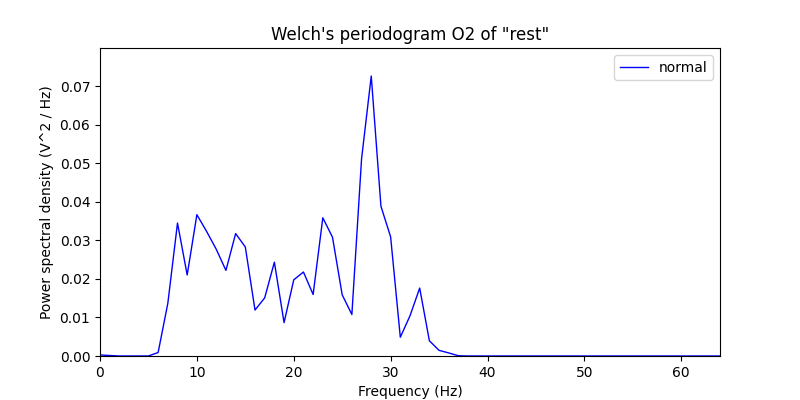

In [85]:
for ch_name in ["FC5", "FC1", "FC2", "FC6", "C3", "Cz", "C4", "CP5", "CP1", "CP2", "CP6", "O1", "Oz", "O2"]:
    plt.figure(figsize=(8, 4))

    ch = ch_idx[ch_name]

    # max_psd = max(normal_psd[15, ch].max(), als_psd[15, ch].max())
    max_psd = normal_psd[1, ch].max()

    plt.plot(freqs, normal_psd[1, ch], color='b', lw=1)
    # plt.plot(freqs, als_psd[15, ch], color='r', lw=1)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    plt.ylim([0, max_psd * 1.1])
    plt.title(f"Welch's periodogram {ch_name} of \"{label}\"")
    plt.xlim([0, freqs.max()])
    
    plt.legend(["normal", "als"])

In [84]:
normal_subject_ds.description

,subject,scenario,event,onset,label,label_idx,trial,split
0,K315,nâng tay trái,Thinking,16.7165,nâng tay trái,3,0,train
1,K315,nâng tay trái,Resting,23.5314,rest,0,0,train
2,K315,nâng tay trái,Resting,40.4585,rest,0,1,train
3,K315,nâng tay trái,Thinking,48.3722,nâng tay trái,3,1,train
4,K315,nâng tay trái,Resting,56.7036,rest,0,2,train
5,K315,nâng tay trái,Resting,74.2479,rest,0,3,train
6,K315,nâng tay trái,Thinking,81.0134,nâng tay trái,3,2,train
7,K315,nâng tay trái,Resting,88.9264,rest,0,4,train
8,K315,nâng tay trái,Resting,104.2386,rest,0,5,train
9,K315,nâng tay phải,Thinking,9.5001,nâng tay phải,2,0,train


In [86]:
bands = [(8, 12, "Alpha"), (12, 20, "Lower Beta"), (20, 30, "Higher Beta")]

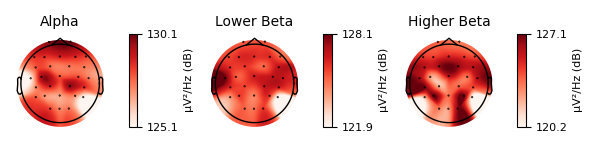

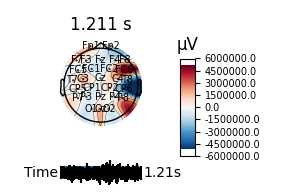

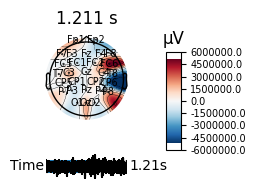

In [88]:
%matplotlib widget
normal_epochs.plot_psd_topomap(bands=bands)
# normal_epochs.average().plot_joint(times=np.arange(0, 2, 0.4))
normal_epochs[1].average().plot_topomap(times="interactive", show_names=True)

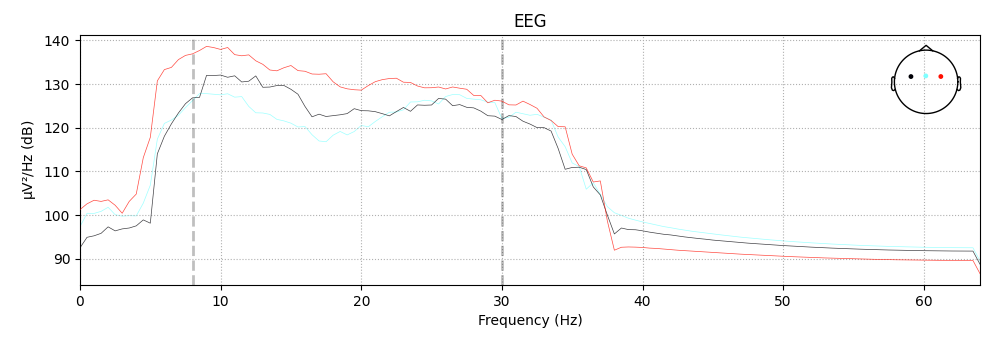

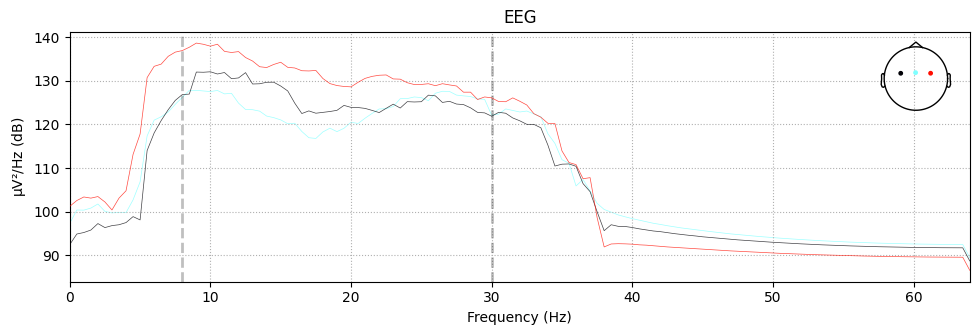

In [80]:
normal_epochs[1].plot_psd(picks=["C3", "Cz", "C4"])